# 크롤링 프로젝트 - 네이버영화 '기생충' : 별점별 리뷰 텍스트 시각화

- WHY? : 영화 '기생충'에 대한 긍정적 & 부정적 인식 차이를 파악하기 위함
- HOW? : 네이버 영화의 별점에 따른 리뷰를 wordcloud 통한 시각화
- 별점이 10점인 리뷰와, 1점인 리뷰에서 자주쓰이는 단어의 긍정적/부정적 의견을 분석

## Step1. html 갖고와서 dictionary 자료형에 {'별점' : '리뷰'} 로 저장.
selenium 과 BeautifulSoup 사용하여 네이버 영화리뷰 - 기생충 페이지 html 긁어오고,
dictionary 에 저장하는 for문 작성.

In [1]:
from bs4 import BeautifulSoup
import urllib.request as req
from urllib.request import  urlopen
from selenium import webdriver
from tqdm import tqdm_notebook
import re

# 빈 dictionary 생성 -  key : 별점, values : 리뷰
dic = dict()

for문 작성 (3600페이지를 액세스 하므로, 예상 소요시간 함께 측정하여 출력)

In [2]:
for j in tqdm_notebook(range(1,3600), desc = '리뷰 페이지 크롤링'):
    url = "https://movie.naver.com/movie/point/af/list.nhn?st=mcode&sword=161967&target=after&page={}".format(j)
    
    # html 내 '별점' 과 '리뷰' 가 함께 들어있는 태그 'div', 클래스 'scroe_result' 갖고오기
    html = req.urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    body = soup.find('div', class_='score_result')
    
    # star 변수에 별점, text 변수에 리뷰 넣기
    for i in soup.findAll('td', {'class':'title'}):
        star = i.find('em').get_text()
        text = re.sub('기생충별점 - 총 \d+점 중\d+|신고', '', i.get_text(strip = True))
                        # 정규표현식 : 각 리뷰마다 반복되는 문구 제거
        if star in dic.keys():
            dic[star] = dic[star] + ' ' +  text
        else:
            dic[star] = text

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [3]:
len(dic)

10

## Step2. 텍스트 필터링하기 위한 불용어 사전 작성
수집된 모든 리뷰의 전체 단어 파악

In [4]:
text = str(dic.values())

konlpy 로 형태소 분석 

In [5]:

from konlpy.tag import Okt
okt = Okt() 
pos = okt.pos(text, norm=True)

len(pos) # 전체 단어 갯수

181010

명사, 형용사만 추출하여 noun_adj에 리스트로 저장.

In [6]:
noun_adj = []
cn = 1
for i in tqdm_notebook(pos):
    if i[1] in ('Noun','Adjective'):  # 명사, 형용사만 뽑기
        noun_adj.append(i[0])
    cn+=1

len(noun_adj) # 명사 형용사 갯수

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


91308

nltk 라이브러리로 최빈 100개 단어 파악

In [7]:
import nltk
nl = nltk.Text(noun_adj)
nl.vocab().most_common(30)

[('영화', 5132),
 ('생각', 1034),
 ('것', 943),
 ('기생충', 764),
 ('감독', 748),
 ('봉준호', 718),
 ('사람', 708),
 ('이', 686),
 ('그', 581),
 ('현실', 525),
 ('보고', 485),
 ('최고', 469),
 ('수', 468),
 ('정말', 458),
 ('작품', 450),
 ('말', 414),
 ('더', 408),
 ('가족', 403),
 ('연기', 400),
 ('진짜', 384),
 ('왜', 354),
 ('냄새', 334),
 ('스토리', 333),
 ('사회', 332),
 ('그냥', 324),
 ('점', 324),
 ('상', 324),
 ('나', 324),
 ('있는', 323),
 ('내', 321)]

### 불용어 사전 작성하기
- rule #1. 명사/형용사로 분류되었으나 큰 의미 없는 단어들 ('수', '나', '그', '것' 등)
- rule #2. 다른 영화들에서도 발견할 수 있는, '일반적'인 리뷰 단어들 ('영화', '배우', '장면', '연출' 등)
- rule #3. 긍정, 부정 모두 비슷하게 높은 빈도로 발견되는 단어들 ('너무', '정말', '아카데미', '가족', '재미'...)

In [8]:
stopwords = ['영화', '그', '것', '관람객', '이', '나', '보고', '말', 
             '수', '내', '세', '상', '입니다', '왜', '말', '없는', '그냥',
             '있는','때', '장면', '감독', '봉준호', '보고', '정말','작품',
             '스토리', '최고', '하나', '연출', '연기', '진짜','그냥',
             '같은','다시','이런', '표현', '가장', '모두', '입니다',
             '모든', '같다', '내', '기생충', '사람', '생각', '사회',
             '현실', '아카데미', '가족', '냄새', '재미', '너무', '영화가', '영화는', '영화를', '내용']

## Step3. 10점 & 1점 각 리뷰 단어 wordcloud 시각화

### 10점만 단어 추출

In [9]:
#### 10점 형태소 분석
text = str(dic['10'])

In [10]:
### text 정제 - 명사, 형용사만 뽑기
from konlpy.tag import Okt
okt = Okt() 
pos = okt.pos(text, norm=True)

len(pos) 

92323

In [11]:
## 명사 형용사만 뽑기
noun_adj = []
cn = 1
for i in tqdm_notebook(pos):
    if i[1] in ('Noun','Adjective'):
        # if i[1] == 'Noun' or 'Adjective':
         # 이렇게하면 안됨!!!!! 괄호로 각각 묶든가!!
        noun_adj.append(i[0])
    cn+=1

text = " ".join(nl) # 다시 텍스트로

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


### 10점 wordcloud 시각화

(-0.5, 999.5, 799.5, -0.5)

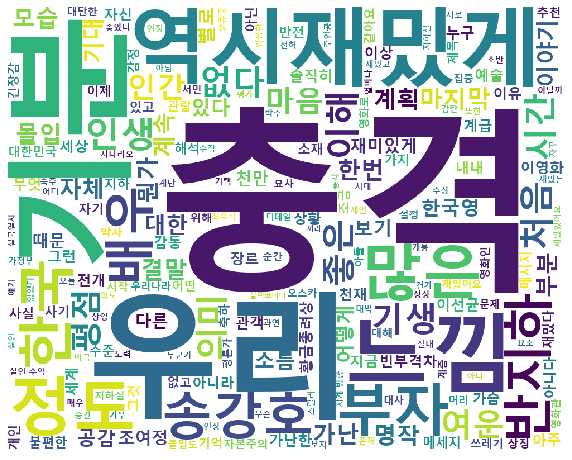

In [12]:
import matplotlib.pylab as plt
from wordcloud import WordCloud
wordcloud = WordCloud(font_path ="c://windows//Fonts/malgunbd.ttf",
                      stopwords = stopwords, # freq에서는 작동안함.
                      background_color = "white",
                      width = 1000,
                      height = 800).generate(text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")

### 1점만 단어 추출

In [13]:
text = str(dic['1'])

### text 정제 - 명사, 형용사만 뽑기
from konlpy.tag import Okt
okt = Okt() 
pos = okt.pos(text, norm=True)

len(pos) 

## 명사 형용사만 뽑기
noun_adj = []
cn = 1
for i in tqdm_notebook(pos):
    if i[1] in ('Noun','Adjective'):
        noun_adj.append(i[0])
    cn+=1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


### 1점만 wordcloud 시각화

(-0.5, 999.5, 799.5, -0.5)

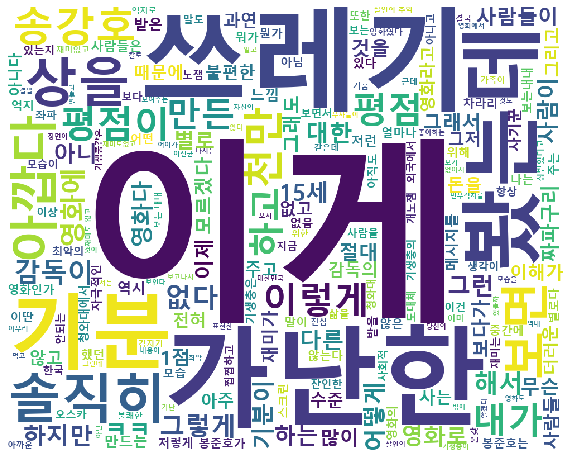

In [14]:
import matplotlib.pylab as plt
from wordcloud import WordCloud
wordcloud = WordCloud(font_path ="c://windows//Fonts/malgunbd.ttf",
                      stopwords = stopwords, # freq에서는 작동안함.
                      background_color = "white",
                      width = 1000,
                      height = 800).generate(text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")

## Step 4. 결론
#### 10점 
- '충격', '느낌'을 받았음에도 '재밌게' 보았다는 의견들. 
- '배우', '송강호'에 대한 팬심으로 긍정적 반응도 있는 것으로 추측 가능하다.

#### 1점 
- '가난한' 이라는 단어가 많은 것으로 보아, 영화에서의 빈부격차가 부정적 의견에 한몫 한듯.
- '감독', '상을', '평점이', '천만', '솔직히' : 상을 받고 언론에 자주 비춰지는 모습때문에 오히려 부정적 인식을 더 키운 것으로도 추측 가능